In [2]:
import matplotlib.pyplot as plt
import networkx as nx

import itertools
import numpy as np
import scipy.special
import cvxpy as cp

In [3]:
def is_cutting_partition(edge, k):
    flag_min = True
    flag_max = True
    for v in edge:
        if v >= k:
            flag_min = False
        if v < k:
            flag_max = False
    return flag_max or flag_min

In [4]:
def generate_H(n, k, p, q):
    H = dict()
    i = 0
    for edge in itertools.combinations(range(n), k): 
        # the partition is like this: first n / 2 vertices vs last n/2 vertices.
        if is_cutting_partition(edge, n/2):
            coin = np.random.binomial(1, p)
        else:
            coin = np.random.binomial(1, q)
        if coin:
            H[i] = edge
            H[i] = list(map(str, H[i]))
            i += 1
    return H

In [5]:
def generate_H_matrix(n, k, p, q):
    size = [n for i in range(k)]
    H = np.zeros(size)
    for edge in itertools.combinations(range(n), k): 
        # the partition is like this: first n / 2 vertices vs last n/2 vertices.
        if is_cutting_partition(edge, n/2):
            coin = np.random.binomial(1, p)
        else:
            coin = np.random.binomial(1, q)
        if coin:
            for subedge in itertools.permutations(edge):
                H[subedge] = 1
    return H

In [6]:
def make_weight_graph(n, k, H):
    if k == 2:
        return H
    res = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            res[i, j] = np.sum(H[i, j, :, :]) / 2 # since [i, j, k, l] and [i, j, l, k] are the same
    return res

In [7]:
def check_coefs(a, b, k):
    if (np.sqrt(a) - np.sqrt(b)) ** 2 / 2 ** (k - 1) > 1:
        print("These are alright")
    else:
        print("These are NOT alright")

In [8]:
n = 100
k = 2
coef = np.log(n) / scipy.special.binom(n - 1, k - 1)
a = 1
b = 20
check_coefs(a, b, k)

These are alright


In [9]:
adj = generate_H_matrix(n, k, coef * a, coef * b)
w = make_weight_graph(n, k, adj)
#H = hnx.Hypergraph(edges)

In [10]:
X = cp.Variable((n,n), symmetric=True)
constraints = [X >> 0, cp.sum(X) == 0]
constraints += [X[i, i] == 1 for i in range(n)]
prob = cp.Problem(cp.Minimize(cp.trace(X @ w)), constraints)

In [11]:
prob.solve(verbose=True)

----------------------------------------------------------------------------
	SCS v2.1.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 10200
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 5050, constraints m = 5151
Cones:	primal zero / dual free vars: 101
	sd vars: 5050, sd blks: 1
Setup time: 2.18e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.27e+20  6.88e+20  1.00e+00 -1.57e+23  3.93e+23  1.10e+23  1.31e-02 
    60| 2.71e-06  2.67e-06  9.41e-08 -4.45e+03 -4.45e+03  2.49e-14  5.86e-01 
----------------------------------------------------------------------------
S

-4450.003834619309

In [13]:
X.value[0, :]

array([ 0.99999905,  0.9999979 ,  0.99999869,  0.99999947,  0.99999848,
        0.99999995,  1.00000005,  0.99999792,  0.99999915,  1.00000617,
        0.99999898,  0.99999918,  0.99999888,  1.00000416,  0.99999858,
        0.99999835,  1.00000173,  0.99999782,  0.99999978,  1.00000041,
        0.99999806,  0.99999959,  0.99999774,  0.99999865,  0.999999  ,
        1.0000028 ,  0.99999939,  1.00000134,  1.00000292,  1.00000077,
        0.99999765,  0.9999985 ,  0.99999874,  1.00000184,  1.00000068,
        0.99999764,  0.99999972,  0.9999983 ,  0.99999806,  0.99999976,
        0.99999905,  1.00000375,  0.9999985 ,  1.0000011 ,  1.00000061,
        0.99999822,  0.99999123,  0.99999808,  0.99999918,  1.00000134,
       -1.00000157, -0.99999762, -1.0000019 , -0.99999935, -0.99999948,
       -0.99999772, -0.99999804, -0.99999827, -0.99999889, -1.00000096,
       -1.00000047, -1.00000102, -1.00000282, -0.99999933, -0.9999997 ,
       -0.99999911, -1.00000314, -0.9999996 , -0.99999737, -1.00

In [20]:
a_s = np.arange(1, 20, 2)
b_s = np.arange(1, 20, 2)

good_pairs = list()
bad_pairs = list()
for a in a_s:
    for b in b_s:
        n = 100
        k = 2
        coef = np.log(n) / scipy.special.binom(n - 1, k - 1)
        #check_coefs(a, b, k)

        adj = generate_H_matrix(n, k, coef * a, coef * b)
        w = make_weight_graph(n, k, adj)

        X = cp.Variable((n,n), symmetric=True)
        constraints = [X >> 0, cp.sum(X) == 0]
        constraints += [X[i, i] == 1 for i in range(n)]
        prob = cp.Problem(cp.Minimize(cp.trace(X @ w)), constraints)
        prob.solve()

        goods = 0
        for i in range(n // 2):
            if X.value[0][i] < 0:
                goods += 1
        for i in range(n // 2, n):
            if X.value[0][i] > 0:
                goods += 1
        acc = max(goods / n, 1 - goods / n)
        if acc > 0.95:
            good_pairs.append([a, b])
        else:
            bad_pairs.append([a, b])
        print("For a = %f and b = %f accuracy is %f" % (a, b, max(goods / n, 1 - goods / n)))
                
#H = hnx.Hypergraph(edges)

For a = 1.000000 and b = 1.000000 accuracy is 0.530000
For a = 1.000000 and b = 3.000000 accuracy is 0.720000
For a = 1.000000 and b = 5.000000 accuracy is 1.000000
For a = 1.000000 and b = 7.000000 accuracy is 1.000000
For a = 1.000000 and b = 9.000000 accuracy is 1.000000
For a = 1.000000 and b = 11.000000 accuracy is 1.000000
For a = 1.000000 and b = 13.000000 accuracy is 1.000000
For a = 1.000000 and b = 15.000000 accuracy is 1.000000
For a = 1.000000 and b = 17.000000 accuracy is 1.000000
For a = 1.000000 and b = 19.000000 accuracy is 1.000000
For a = 3.000000 and b = 1.000000 accuracy is 0.540000
For a = 3.000000 and b = 3.000000 accuracy is 0.500000
For a = 3.000000 and b = 5.000000 accuracy is 0.540000
For a = 3.000000 and b = 7.000000 accuracy is 0.970000
For a = 3.000000 and b = 9.000000 accuracy is 1.000000
For a = 3.000000 and b = 11.000000 accuracy is 1.000000
For a = 3.000000 and b = 13.000000 accuracy is 1.000000
For a = 3.000000 and b = 15.000000 accuracy is 1.000000
Fo

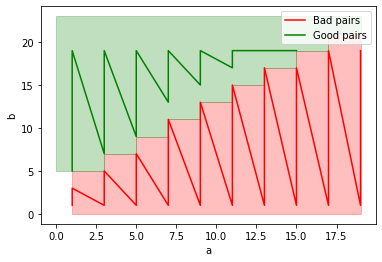

In [71]:
plt.plot(bad_a, bad_b, color='r', label='Bad pairs')
plt.plot(good_a, good_b, color='g', label='Good pairs')
plt.xlabel('a')
plt.ylabel('b')

plt.fill_between(np.arange(1, 20, 2), 2 + np.arange(1, 20, 2), step="pre", alpha=0.25, color = 'r')
plt.fill_betweenx(4 + np.arange(1, 20, 2), np.arange(1, 20, 2), step="pre", alpha=0.25, color = 'g')



plt.legend()
plt.show()

In [35]:
good_sorted = good_pairs#sorted(good_pairs, key=lambda x: x[0] + x[1])
bad_sorted = bad_pairs#sorted(bad_pairs, key=lambda x: x[0] + x[1])

In [47]:
good_a = [x[0] for x in good_sorted]
good_b = [x[1] for x in good_sorted]

bad_a = [x[0] for x in bad_sorted]
bad_b = [x[1] for x in bad_sorted]

In [41]:
a_s = np.arange(1, 40, 4)
b_s = np.arange(1, 40, 4)

good_pairs_4 = list()
bad_pairs_4 = list()
for a in a_s:
    for b in b_s:
        n = 50
        k = 4
        coef = np.log(n) / scipy.special.binom(n - 1, k - 1)
        #check_coefs(a, b, k)

        adj = generate_H_matrix(n, k, coef * a, coef * b)
        w = make_weight_graph(n, k, adj)

        X = cp.Variable((n,n), symmetric=True)
        constraints = [X >> 0, cp.sum(X) == 0]
        constraints += [X[i, i] == 1 for i in range(n)]
        prob = cp.Problem(cp.Minimize(cp.trace(X @ w)), constraints)
        prob.solve()

        goods = 0
        for i in range(n // 2):
            if X.value[0][i] < 0:
                goods += 1
        for i in range(n // 2, n):
            if X.value[0][i] > 0:
                goods += 1
        acc = max(goods / n, 1 - goods / n)
        if acc > 0.95:
            good_pairs_4.append([a, b])
        else:
            bad_pairs_4.append([a, b])
        print("For a = %f and b = %f accuracy is %f" % (a, b, max(goods / n, 1 - goods / n)))
                
#H = hnx.Hypergraph(edges)

For a = 1.000000 and b = 1.000000 accuracy is 0.580000
For a = 1.000000 and b = 5.000000 accuracy is 0.720000
For a = 1.000000 and b = 9.000000 accuracy is 0.840000
For a = 1.000000 and b = 13.000000 accuracy is 0.880000
For a = 1.000000 and b = 17.000000 accuracy is 0.960000
For a = 1.000000 and b = 21.000000 accuracy is 0.980000
For a = 1.000000 and b = 25.000000 accuracy is 1.000000
For a = 1.000000 and b = 29.000000 accuracy is 1.000000
For a = 1.000000 and b = 33.000000 accuracy is 1.000000
For a = 1.000000 and b = 37.000000 accuracy is 1.000000
For a = 5.000000 and b = 1.000000 accuracy is 0.600000
For a = 5.000000 and b = 5.000000 accuracy is 0.580000
For a = 5.000000 and b = 9.000000 accuracy is 0.620000
For a = 5.000000 and b = 13.000000 accuracy is 0.600000
For a = 5.000000 and b = 17.000000 accuracy is 0.820000
For a = 5.000000 and b = 21.000000 accuracy is 0.660000
For a = 5.000000 and b = 25.000000 accuracy is 0.960000
For a = 5.000000 and b = 29.000000 accuracy is 0.88000

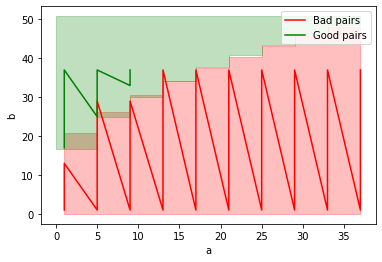

In [103]:
plt.plot(bad_a, bad_b, color='r', label='Bad pairs')
plt.plot(good_a, good_b, color='g', label='Good pairs')
plt.xlabel('a')
plt.ylabel('b')
plt.fill_between(np.arange(1, 40, 4), 5 + np.sqrt(np.arange(1, 40, 4) * 50), step="pre", alpha=0.25, color = 'r')
plt.fill_betweenx(10 + np.sqrt(np.arange(1, 40, 4) * 45), np.arange(1, 40, 4), step="pre", alpha=0.25, color = 'g')
plt.legend()
plt.show()

In [72]:
good_a = [x[0] for x in good_pairs_4]
good_b = [x[1] for x in good_pairs_4]

bad_a = [x[0] for x in bad_pairs_4]
bad_b = [x[1] for x in bad_pairs_4]